In [158]:
# Tässä aikasarjaennuste. Tein sen nyt siisteimmästä datasta, mutta ennustemallithan pätevät kaikkiin datoihin.

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Määrittelen kuvaajille vähän isomman koon, on kivempi sitten katsella.

plt.rcParams['figure.figsize'] = [12,6]
plt.style.use('seaborn-white')

In [159]:
df1 = pd.read_excel('http://taanila.fi/CO2.xlsx')
df1.head()

,Kuukausi,CO2
0,1999-12,368.04
1,2000-1,369.25
2,2000-2,369.50
3,2000-3,370.56
4,2000-4,371.82


In [160]:
# Tässä muunnan päivämäärät indeksiin, oletuksena näemmä tulee kuukauden ensimmäinen päivä. Päivää ei alkuperäisessä datassa
# mainita, joten oletetaan että se olisi se mittauspäivä.

df1.index = pd.to_datetime(df1['Kuukausi'], format='%Y-%m')
df1.head()

,Kuukausi,CO2
Kuukausi,,
1999-12-01,1999-12,368.04
2000-01-01,2000-1,369.25
2000-02-01,2000-2,369.50
2000-03-01,2000-3,370.56
2000-04-01,2000-4,371.82


In [161]:
# Ylimääräinen sarake pois

df1.drop('Kuukausi', axis=1)

,CO2
Kuukausi,
1999-12-01,368.04
2000-01-01,369.25
2000-02-01,369.50
2000-03-01,370.56
2000-04-01,371.82
...,...
2019-08-01,409.95
2019-09-01,408.54
2019-10-01,408.53


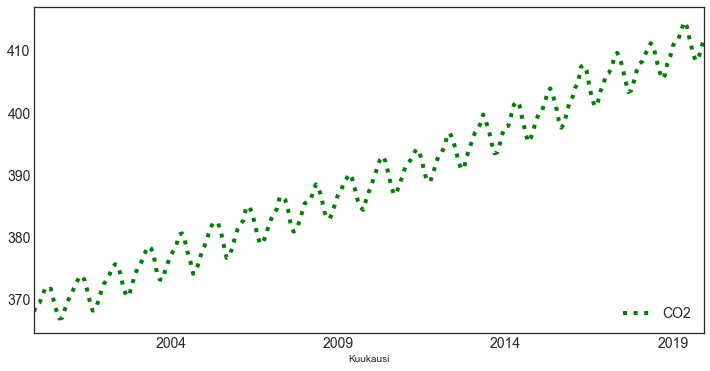

In [162]:
# Plottaan datan ja kokeilin vähän eri muuttujia plot-funktiolle

df1.plot(fontsize=14, linewidth=4, color='green', linestyle=':')
plt.legend(loc='lower right', fontsize=14)

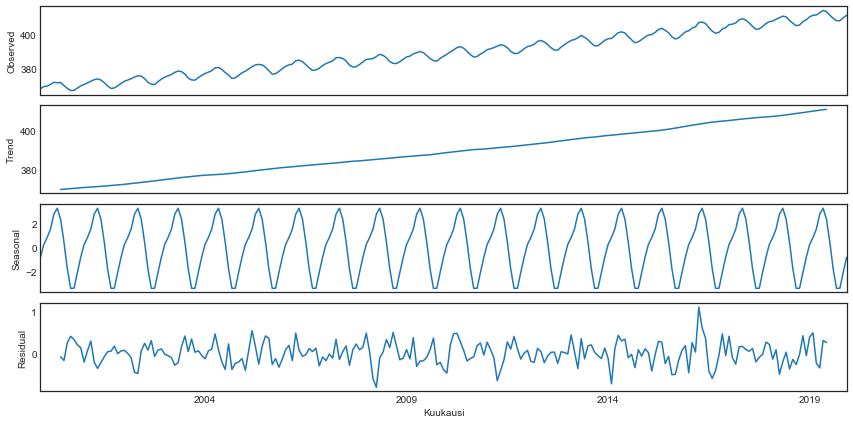

In [163]:
# Tässä nämä kausivaihtelut ja trendi. Halusin ottaa selvää miksi nämä tulostuvat kaksi kertaa ja löysin muutamakin
# syyn sille, mutta itselläni toimiva ratkaisu oli laittaa puolipiste koodin loppuun.
# Ilmeisesti kun koodi päättyy plot-funktioon tapahtuu kaksinkertainen tulostus, sinne loppuun siis voisi
# laittaa jotain muutakin.

# https://github.com/statsmodels/statsmodels/issues/1265

from statsmodels.tsa.api import seasonal_decompose
fig = seasonal_decompose(df1['CO2'])
fig.plot();

In [120]:
# Tehdään tuo ExponentialSmoothing malli. Päättelin, että tässä mennään kuukausitasolla, joten periodeja on 12.
# En nopeasti löytänyt freq-arvoa kuukauden ensimmäiselle, mutta myöhemmin koodi tajusi olettaa arvon MS olevan oikea.

from statsmodels.tsa.api import ExponentialSmoothing
malli = ExponentialSmoothing(df1['CO2'], trend='add', seasonal='mul', seasonal_periods=12, freq='MS').fit()

In [121]:
# Tässä sitten ennusteet, jotka osuvat koska data on niin siistiä.

df1['Ennuste'] = malli.fittedvalues
df1

,Kuukausi,CO2,Ennuste
Kuukausi,,,
1999-12-01,1999-12,368.04,367.969324
2000-01-01,2000-1,369.25,369.196869
2000-02-01,2000-2,369.50,369.926373
2000-03-01,2000-3,370.56,370.537499
2000-04-01,2000-4,371.82,371.892871
...,...,...,...
2019-08-01,2019-8,409.95,409.731063
2019-09-01,2019-9,408.54,408.340320
2019-10-01,2019-10,408.53,408.637814


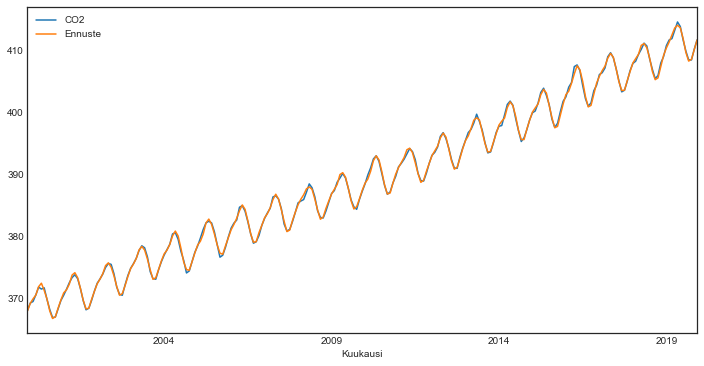

In [122]:
# Ennuste ja toteuma plotattuna

df1.plot()

In [123]:
# Ennustevirheen määrä

df1['Ennustevirhe'] = malli.resid
df1

,Kuukausi,CO2,Ennuste,Ennustevirhe
Kuukausi,,,,
1999-12-01,1999-12,368.04,367.969324,0.070676
2000-01-01,2000-1,369.25,369.196869,0.053131
2000-02-01,2000-2,369.50,369.926373,-0.426373
2000-03-01,2000-3,370.56,370.537499,0.022501
2000-04-01,2000-4,371.82,371.892871,-0.072871
...,...,...,...,...
2019-08-01,2019-8,409.95,409.731063,0.218937
2019-09-01,2019-9,408.54,408.340320,0.199680
2019-10-01,2019-10,408.53,408.637814,-0.107814


In [127]:
# Tässä sitten ennustevirheen kuvaajia

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [133]:
print('Mean squared error', mse(df1['CO2'], df1['Ennuste']))
print('Mean absolute error', mae(df1['CO2'], df1['Ennuste']))

Mean squared error 0.09349180053226352
Mean absolute error 0.23757588305640698


Text(0, 0.5, 'Ennustevirhe')

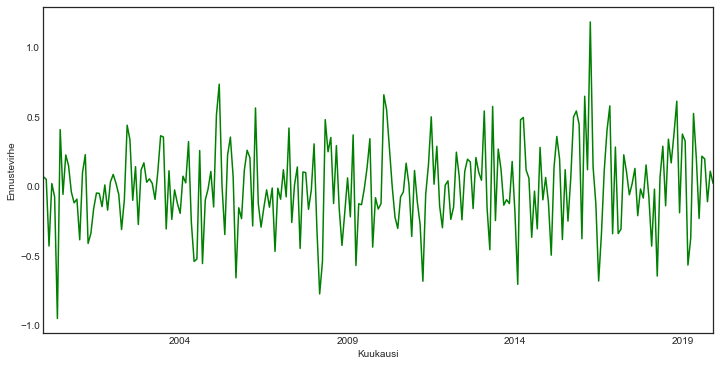

In [135]:
df1['Ennustevirhe'].plot(color='green')
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut')

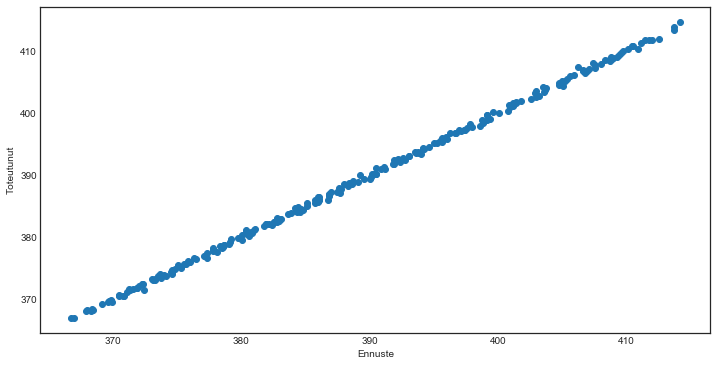

In [138]:
# Ja kuten scatterplotistakin nähdään, niin data käyttäytyy ihan lineaarisesti. Ei mitenkään mielenkiintoisin datalähde,
# mutta koodithan toimivat samalla tavalla.

plt.scatter(x=df1['Ennuste'], y=df1['CO2'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut')

In [139]:
# Tässä tarkastan vain viimeisen mittauspäivämäärän.

df1

,Kuukausi,CO2,Ennuste,Ennustevirhe
Kuukausi,,,,
1999-12-01,1999-12,368.04,367.969324,0.070676
2000-01-01,2000-1,369.25,369.196869,0.053131
2000-02-01,2000-2,369.50,369.926373,-0.426373
2000-03-01,2000-3,370.56,370.537499,0.022501
2000-04-01,2000-4,371.82,371.892871,-0.072871
...,...,...,...,...
2019-08-01,2019-8,409.95,409.731063,0.218937
2019-09-01,2019-9,408.54,408.340320,0.199680
2019-10-01,2019-10,408.53,408.637814,-0.107814


In [146]:
# Aloitetaan oikea ennustaminen siis 1.1.2020. Laitoin ennusteen neljälle vuodelle, jotta se näkyisi paremmin kuvaajassa.

index = pd.date_range('2020-1-1', periods=48, freq='MS')
ennusteet = malli.forecast(48)
df_ennuste = pd.DataFrame(columns = ['Ennuste'], data = ennusteet, index = index)

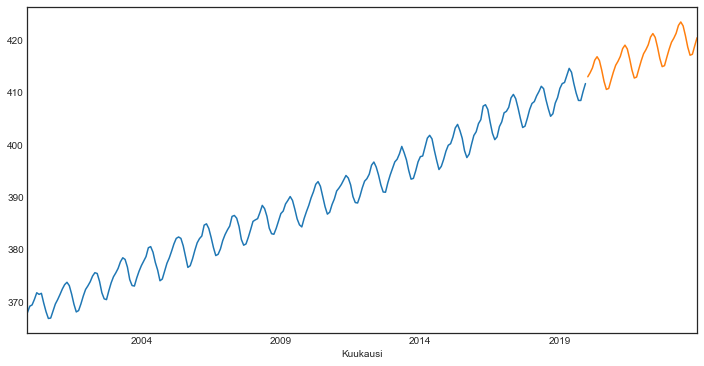

In [147]:
# Ja tässä näkyy sitten toteuma 1.12.2019 asti ja sen jälkeen ennuste kuukausittain.

df1['CO2'].plot()
df_ennuste['Ennuste'].plot()

In [155]:
# Yhdistetään dataframet

df_CO2ennuste = pd.concat([df1, df_ennuste])
df_CO2ennuste

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,CO2,Ennuste,Ennustevirhe,Kuukausi
1999-12-01,368.04,367.969324,0.070676,1999-12
2000-01-01,369.25,369.196869,0.053131,2000-1
2000-02-01,369.50,369.926373,-0.426373,2000-2
2000-03-01,370.56,370.537499,0.022501,2000-3
2000-04-01,371.82,371.892871,-0.072871,2000-4
...,...,...,...,...
2023-08-01,NaN,418.720844,NaN,NaN
2023-09-01,NaN,417.170295,NaN,NaN
2023-10-01,NaN,417.355570,NaN,NaN
2023-11-01,NaN,418.967110,NaN,NaN


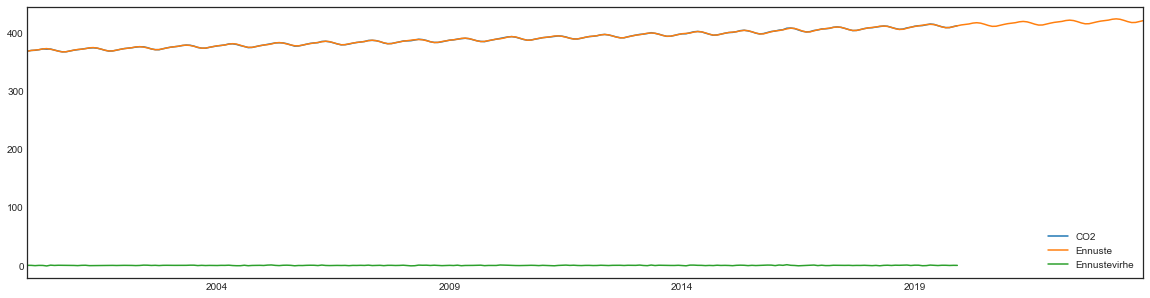

In [154]:
# Tässä vielä plottasin yhdistetyn dataframen.

plt.rcParams['figure.figsize']= [20,5]
df_CO2ennuste.plot()

In [152]:
malli.params

{'smoothing_level': 0.5624127008366205,
 'smoothing_slope': 1.3350464740853778e-23,
 'smoothing_seasonal': 0.0,
 'damping_slope': nan,
 'initial_level': 388.5661234690543,
 'initial_slope': 0.19282238243953956,
 'initial_seasons': array([0.9465231 , 0.94910743, 0.95043474, 0.95215038, 0.95512734,
        0.9562077 , 0.95412921, 0.94948593, 0.94413534, 0.94023036,
        0.94023932, 0.94346004]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}